# PINN using functorch and pytorch Lightning

In [2]:
#importing
import torch
import torch.nn as nn
import torch.func as func
import torchopt
from torch.utils.data import DataLoader, random_split, TensorDataset
import pytorch_lightning as pl
import seaborn as sn
import torchmetrics
from torchmetrics import Metric

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import pandas as pd
import numpy as np

NOTE: Redirects are currently not supported in Windows or MacOs.


## Loading the data

In [3]:
# train data
X = pd.read_csv('../Data/NN data/nn_train_mei_17-26.csv')
X.drop(columns=["Unnamed: 0"], inplace=True)
X_input = X[['t', 'x', 'y', 'Hot gas pipe', 'Liquid pipe', 'Suction pipe', 'Door', 
             'Fridge', 'Environment', 'Energy', 'Water-1', 'Water-2', 'Water-3']]
X_output = X[['u']]

display(X.head())
print(X.shape)
# convert to Tensor
X_input_tensor = torch.tensor(X_input.values, dtype=torch.float32, requires_grad=True)
print(X_input_tensor[0:2])
X_output_tensor = torch.tensor(X_output.values, dtype=torch.float32)
print(X_output_tensor[0:2])

,t,x,y,u,Hot gas pipe,Liquid pipe,Suction pipe,Door,Fridge,Environment,Energy,Water-1,Water-2,Water-3
0,0,4,9.5,14.760000,24.6,24.4,24.0,1.0,23.7,24.9,0.0,14.76,14.76,14.76
1,0,71,68.0,14.780000,24.6,24.4,24.0,1.0,23.7,24.9,0.0,14.78,14.78,14.78
2,0,22,39.5,16.370000,24.6,24.4,24.0,1.0,23.7,24.9,0.0,16.37,16.37,16.37
3,1,4,9.5,14.771176,24.6,24.4,24.0,1.0,23.7,24.9,0.0,14.76,14.76,14.76
4,1,71,68.0,14.810000,24.6,24.4,24.0,1.0,23.7,24.9,0.0,14.78,14.78,14.78


(22929, 14)
tensor([[ 0.0000,  4.0000,  9.5000, 24.6000, 24.4000, 24.0000,  1.0000, 23.7000,
         24.9000,  0.0000, 14.7600, 14.7600, 14.7600],
        [ 0.0000, 71.0000, 68.0000, 24.6000, 24.4000, 24.0000,  1.0000, 23.7000,
         24.9000,  0.0000, 14.7800, 14.7800, 14.7800]],
       grad_fn=<SliceBackward0>)
tensor([[14.7600],
        [14.7800]])


In [4]:
# validation data
Y = pd.read_csv('../Data/NN data/nn_val_mei_17-26.csv')
Y.drop(columns=["Unnamed: 0"], inplace=True)
Y_input = Y[['t', 'x', 'y', 'Hot gas pipe', 'Liquid pipe', 'Suction pipe', 'Door', 
             'Fridge', 'Environment', 'Energy', 'Water-1', 'Water-2', 'Water-3']]
Y_output = Y[['u']]
display(Y.head())
print(Y.shape)

# convert to Tensor
Y_input_tensor = torch.tensor(Y_input.values, dtype=torch.float32)
Y_output_tensor = torch.tensor(Y_output.values, dtype=torch.float32)

,t,x,y,u,Hot gas pipe,Liquid pipe,Suction pipe,Door,Fridge,Environment,Energy,Water-1,Water-2,Water-3
0,7643,22,39.5,6.854412,60.3,37.2,9.8,0.0,-4.1,27.8,950.0,6.710571,6.585806,6.434194
1,7643,4,9.5,7.947059,60.3,37.2,9.8,0.0,-4.1,27.8,950.0,7.773143,7.616774,7.400800
2,7643,71,68.0,7.751765,60.3,37.2,9.8,0.0,-4.1,27.8,950.0,7.576000,7.389706,7.185556
3,7644,4,9.5,8.109630,62.1,35.7,6.9,0.0,0.9,27.1,850.0,7.947059,7.773143,7.616774
4,7644,71,68.0,7.916000,62.1,35.7,6.9,0.0,0.9,27.1,850.0,7.751765,7.576000,7.389706


(7644, 14)


In [5]:
# test data
Z = pd.read_csv('../Data/NN data/nn_test_mei_17-26.csv')
Z.drop(columns=['Unnamed: 0'], inplace=True)
Z_input = Z[['t', 'x', 'y', 'Hot gas pipe', 'Liquid pipe', 'Suction pipe', 'Door', 
             'Fridge', 'Environment', 'Energy', 'Water-1', 'Water-2', 'Water-3']]
Z_output = Z[['u']]

display(Z.head())
print(Z.shape)
# convert to Tensor
Z_input_tensor = torch.tensor(Z_input.values, dtype=torch.float32)
Z_output_tensor = torch.tensor(Z_output.values, dtype=torch.float32)

,t,x,y,u,Hot gas pipe,Liquid pipe,Suction pipe,Door,Fridge,Environment,Energy,Water-1,Water-2,Water-3
0,10191,4,9.5,3.683143,58.0,33.3,6.2,0.0,0.6,26.0,650.0,3.690000,3.690000,3.676154
1,10191,71,68.0,3.248235,58.0,33.3,6.2,0.0,0.6,26.0,650.0,3.250000,3.250000,3.190000
2,10191,22,39.5,3.693429,58.0,33.3,6.2,0.0,0.6,26.0,650.0,3.771176,3.750000,3.699231
3,10192,71,68.0,3.220000,55.4,32.5,7.0,0.0,2.1,25.6,100.0,3.248235,3.250000,3.250000
4,10192,22,39.5,3.690000,55.4,32.5,7.0,0.0,2.1,25.6,100.0,3.693429,3.771176,3.750000


(7644, 14)


## Create NN

In [6]:
class NN(pl.LightningModule):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        condition_losses = []

        for condition_name, samples in batch.items():
            condition = self.problem.conditions[condition_name]

            # PINN loss: equation evaluated on location or input_points
            if hasattr(condition, 'equation'):
                target = condition.equation.residual(samples, self.forward(samples))
                loss = self._loss(torch.zeros_like(target), target)
            # PINN loss: evaluate model(input_points) vs output_points
            elif hasattr(condition, 'output_points'):
                input_pts, output_pts = samples
                loss = self._loss(self.forward(input_pts), output_pts)

            condition_losses.append(loss * condition.data_weight)

        # TODO Fix the bug, tot_loss is a label tensor without labels
        # we need to pass it as a torch tensor to make everything work
        total_loss = sum(condition_losses)
        return total_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        self.log('test_loss', loss)
        return loss
    
    def configure_optimizers(self, lr=1e-3):
        return torch.optim.Adam(self.parameters(), lr=lr)

    def train_dataloader(self, batchsize=64):
        return DataLoader(TensorDataset(X_input_tensor, X_output_tensor), batch_size=batchsize, shuffle=True)
    
    def val_dataloader(self, batchsize=64):
        return DataLoader(TensorDataset(Y_input_tensor, Y_output_tensor), batch_size=batchsize, shuffle=False)
    
    def test_dataloader(self, batchsize=64):
        return DataLoader(TensorDataset(Z_input_tensor, Z_output_tensor), batch_size=batchsize, shuffle=False)
    

## Define PDE, Boundary and initial condition losses

In [7]:
input_size = X_input.shape[1]
output_size = X_output.shape[1]

# create the PINN model and make it functional using functorch utilities
model = NN(input_size=input_size, output_size=output_size)

x = X_input_tensor
print(x[:, 1])
def loss_fn(pred: torch.Tensor, target: torch.Tensor):
    # PDE loss

    # compute derivative of the prediction with respect to x
    pred_x = torch.autograd.grad(pred, x, torch.ones_like(pred), create_graph=True)[0]
    
    

    # compute second order derivatives


    # boundary loss


    loss_NN = nn.MSELoss()(pred, target)

    loss_value = loss_NN

    return loss_value


tensor([ 4., 71., 22.,  ..., 71., 22.,  4.], grad_fn=<SelectBackward0>)


## Train and validate the model

In [8]:
# Parameters
input_size = X_input.shape[1]
output_size = X_output.shape[1]
learning_rate = 0.001
batch_size = 64
num_epochs = 10

# Loss
model.loss = loss_fn

# Data
train_loader = model.train_dataloader(batch_size)
val_loader = model.val_dataloader(batch_size)
test_loader = model.test_dataloader(batch_size)

# initialize trainer
trainer = pl.Trainer(max_epochs=num_epochs, accelerator='cpu')
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 5.1 K 
-------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model pa

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## Testing and evaluating the results

In [11]:
# test model
trainer.test()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /Users/Bo/Desktop/School/Jaar3/Scriptie/Code/lightning_logs/version_58/checkpoints/epoch=9-step=3590.ckpt
Loaded model weights from the checkpoint at /Users/Bo/Desktop/School/Jaar3/Scriptie/Code/lightning_logs/version_58/checkpoints/epoch=9-step=3590.ckpt
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consi

Testing DataLoader 0: 100%|██████████| 120/120 [00:01<00:00, 117.48it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6083737015724182     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6083737015724182}]

,train_loss,val_loss,test_loss
epoch,,,
0,39.306480,NaN,NaN
0,3.987778,NaN,NaN
0,1.401397,NaN,NaN
0,1.368974,NaN,NaN
0,1.502220,NaN,NaN


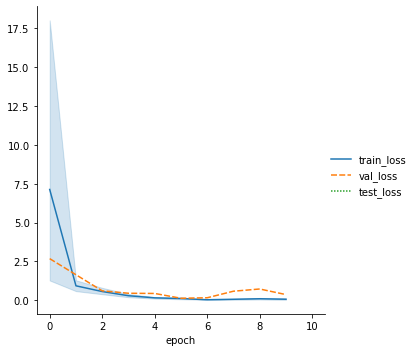

In [12]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [13]:
# predict
model.eval()
with torch.no_grad():
    y_pred = model(Z_input_tensor)
    loss = model.loss(y_pred, Z_output_tensor)
    print(f"Loss: {loss:.8f}")

# tensor to numpy
prediction_values = y_pred.numpy()
true_values = Z_output_tensor.numpy()

# plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(true_values))), y=true_values.flatten(), mode='lines', name='True'))
fig.add_trace(go.Scatter(x=list(range(len(prediction_values))), y=prediction_values.flatten(), mode='lines', name='Prediction'))
fig.update_layout(title='Prediction vs True', xaxis_title='Time', yaxis_title='Temperature')
fig.show()

Loss: 0.60837376


### Functorch stuff

In [11]:
class NN(nn.Module):
    def __init__(
        self,
        num_inputs: int = 1,
        num_outputs: int = 1,
        num_hidden: int = 1,
        dim_hidden: int = 1,
        act: nn.Module = nn.Tanh(),
    ) -> None:
        """Simple neural network with linear layers and non-linear activation function
        This class is used as universal function approximator for the solution of
        partial differential equations using PINNs
        Args:
            num_inputs (int, optional): The number of input dimensions
            num_outputs (int, optional): The number of outputs of the model, in general is 1
            num_hidden (int, optional): The number of hidden layers in the model
            dim_hidden (int, optional): The number of neurons for each hidden layer
            act (nn.Module, optional): The type of non-linear activation function to be used
        """
        super().__init__()

        self.layer_in = nn.Linear(num_inputs, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, num_outputs)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        return self.layer_out(out)

In [12]:
from functorch import make_functional, grad, vmap

# create the PINN model and make it functional using functorch utilities
model = NN()
fmodel, params = make_functional(model)

def f(x: torch.Tensor, params: torch.Tensor) -> torch.Tensor:
    # only a single element is supported thus unsqueeze must be applied
    # for batching multiple inputs, `vmap` must be used as below
    x_ = x.unsqueeze(0)
    res = fmodel(params, x_).squeeze(0)
    return res

# use `vmap` primitive to allow efficient batching of the input
f_vmap = vmap(f, in_dims=(0, None))

# return function for computing higher order gradients with respect
# to input by simply composing `grad` calls and use again `vmap` for
# efficient batching of the input
dfdx = vmap(grad(f), in_dims=(0, None))
d2fdx2 = vmap(grad(grad(f)), in_dims=(0, None))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/_functorch/deprecated.py:97: UserWarning:

We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/_functorch/deprecated.py:58: UserWarning:

We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html

/Li

In [13]:
R = 1.0  # rate of maximum population growth parameterizing the equation
X_BOUNDARY = 0.0  # boundary condition coordinate
F_BOUNDARY = 0.5  # boundary condition value


def loss_fn(params: torch.Tensor, x: torch.Tensor) -> torch.Tensor:

    # interior loss
    f_value = f_vmap(x, params)
    interior = dfdx(x, params) - R * f_value * (1 - f_value)

    # boundary loss
    x0 = X_BOUNDARY
    f0 = F_BOUNDARY
    x_boundary = torch.tensor([x0])
    f_boundary = torch.tensor([f0])
    boundary = f_vmap(x_boundary, params) - f_boundary

    loss = nn.MSELoss()
    loss_value = loss(interior, torch.zeros_like(interior)) + loss(
        boundary, torch.zeros_like(boundary)
    )

    return loss_value

In [14]:
# choose the configuration
batch_size = 30  # number of colocation points sampled in the domain
num_iter = 100  # maximum number of iterations
learning_rate = 1e-1  # learning rate
domain = (-5.0, 5.0)  # logistic equation domain

# choose optimizer with functional API using functorch
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

# train the model
for i in range(num_iter):

    # sample colocations points in the domain randomly at each epoch
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])

    # update the parameters using the functional API
    loss = loss_fn(params, x)
    params = optimizer.step(loss, params)

    print(f"Iteration {i} with loss {float(loss)}")

Iteration 0 with loss 3.1161837577819824
Iteration 1 with loss 1.7665841579437256
Iteration 2 with loss 0.9638484716415405
Iteration 3 with loss 0.5573378205299377
Iteration 4 with loss 0.26031291484832764
Iteration 5 with loss 0.1401580572128296
Iteration 6 with loss 0.09672214090824127
Iteration 7 with loss 0.07434478402137756
Iteration 8 with loss 0.08948375284671783
Iteration 9 with loss 0.10277165472507477
Iteration 10 with loss 0.13193379342556
Iteration 11 with loss 0.1359812617301941
Iteration 12 with loss 0.19631457328796387
Iteration 13 with loss 0.21327154338359833
Iteration 14 with loss 0.24476897716522217
Iteration 15 with loss 0.25221559405326843
Iteration 16 with loss 0.25393447279930115
Iteration 17 with loss 0.24947024881839752
Iteration 18 with loss 0.23438483476638794
Iteration 19 with loss 0.21325591206550598
Iteration 20 with loss 0.18858323991298676
Iteration 21 with loss 0.1632629930973053
Iteration 22 with loss 0.1393880695104599
Iteration 23 with loss 0.1181951